In [ ]:
import numpy as np
import matplotlib.pyplot as plt
res = np.load('/home/user/data2/ICML_rebuttal/savings/uncond/etth2_24_S/KoVAEorig/cond_None_dtm_True_syn.npy')
# res = np.load('/home/user/data/ICML_rebuttal/savings/uncond/etth2_24_S/KoVAE_orig/cond_None_dtm_True_syn.npy')
start = np.random.randint(0, len(res))
_ = plt.plot(res[start, :, :].squeeze().T)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('/home/user/workspaces/THU-timeseries/ETT-small/ETTh2.csv', index_col=0)
# df.values.shape
start = np.random.randint(0, len(df)-24)
_ = plt.plot(df.values[start:start+24, :])

In [ ]:
from abc import ABC, abstractmethod
from typing import List, Optional, Literal
from lightning import LightningModule
import torch
from torch.nn import functional as F

def _condition_shape_check(n_sample, condition, cond_type):
    assert n_sample >=1
    if cond_type is None:
    
        if condition.shape[0] == 1:
            condition = condition.repeat(
                n_sample, *[1 for _ in range(len(condition.shape) - 1)]
            )
        elif condition.shape[0] == n_sample:
            pass
        else:
            raise ValueError(
                "The batch size of the given condition should be the same as n_sample or just 1."
            )
 
    return condition


class BaseModel(ABC, LightningModule):
    """Base class for generative models in PyTorch Lightning"""
    ALLOW_CONDITION = ...
    
    def __init__(self, seq_len, seq_dim, condition, lr, **kwargs):
        super().__init__()
        if condition not in self.ALLOW_CONDITION:
            raise ValueError(f"Condition '{condition}' not allowed. Choose from {self.ALLOW_CONDITION}")
    
    @torch.no_grad()  # wrap with torch.no_grad()
    def sample(self, n_sample: int = 1, condition=None, **kwargs):
        """Generate samples from the generative model"""
        condition = _condition_shape_check(n_sample, condition, self.condition)
        self.eval()
        return self._sample_impl(n_sample, condition, **kwargs)

    @abstractmethod
    def _sample_impl(self, n_sample: int = 1, condition=None, **kwargs) -> torch.Tensor:
        """Actual implementation of the sampling process"""


class MyModel(BaseModel):
    """AAAAAAA

    Args:
        BaseModel (_type_): _description_

    Returns:
        _type_: _description_
    """
    ALLOW_CONDITION = [None, 'predict']
    def __init__(self, seq_len, seq_dim, condition, lr, **kwargs):
        """aaaaaaa

        Args:
            seq_len (_type_): _description_
            seq_dim (_type_): _description_
            condition (_type_): _description_
            lr (_type_): _description_
        """
        super().__init__(seq_len, seq_dim, condition, lr, **kwargs)
    
    def _sample_impl(self, n_sample = 1, condition=None, **kwargs):
        return super()._sample_impl(n_sample, condition, **kwargs)

MyModel
model = MyModel(24, 1, 'impute', 0.001)

In [ ]:
import torch

total_seq_len = 64
num_samples = 200
t = torch.linspace(0, 4 * torch.pi, total_seq_len).float()
curves = []
labels = []
for _ in range(num_samples):
    a = torch.rand(1).item() * 0.5  # Initial radius
    b = torch.rand(1).item() * 0.2  # Growth rate

    direction = torch.randint(0, 2, (1,)).item()  # 0=clockwise, 1=ccw

    r = a + b * t
    if direction == 0:
        x = r * torch.cos(t)
        y = r * torch.sin(t)
    else:
        x = -r * torch.cos(t)
        y = r * torch.sin(t)

    x += torch.randn_like(x) * 0.01
    y += torch.randn_like(y) * 0.01

    curve = torch.stack([x, y], dim=1)
    curves.append(curve)
    labels.append(direction)
data, class_cond = torch.stack(curves), torch.tensor(labels).unsqueeze(-1)
print(data.shape, class_cond.shape)

class_cond[1,...,...]

In [ ]:
import torchaudio.transforms as T
import torch

n_fft = 200
hop_length = 10
data = torch.randn(32, 64, 5)
hop_length = 8
print((data.shape[1]) // hop_length + 1)
data = torch.permute(
    data, (0, 2, 1)
)  # we permute to match requirements of torchaudio.transforms.Spectrogram
spec = T.Spectrogram(n_fft=15, hop_length=hop_length, center=True, power=None).to(data.device)
transformed_data = spec(data)
transformed_data.shape

In [ ]:
import numpy as np

def sine_data_generation(no, seq_len, dim, freq_scale=1):

    """Sine data generation.
  
    Args:
    
    - no: the number of samples
    - seq_len: sequence length of the time-series
    - dim: feature dimensions
    
    Returns:
    - data: generated data
    
    """
    # Initialize the output
    data = list()

    # Generate sine data
    for i in range(no):      
        # Initialize each time-series
        temp = list()
        # For each feature
        for k in range(dim):
            # Randomly drawn frequency and phase
            freq = np.random.uniform(0.05, 0.4)            
            phase = np.random.uniform(0, 1.5)
                
            # Generate sine signal based on the drawn frequency and phase
            temp_data = [np.sin(freq * j + phase) for j in range(seq_len)] 
            temp.append(temp_data)
            
        # Align row/column
        temp = np.transpose(np.asarray(temp))        
        # Normalize to [0,1]
        temp = (temp + 1)*0.5
        # Stack the generated data
        data.append(temp)
                    
    return data

In [11]:
from torchvision.datasets.utils import download_url
import tarfile
import os
import re
import numpy as np
import pandas as pd

attributes = [
    "DiasABP",
    "HR",
    "Na",
    "Lactate",
    "NIDiasABP",
    "PaO2",
    "WBC",
    "pH",
    "Albumin",
    "ALT",
    "Glucose",
    "SaO2",
    "Temp",
    "AST",
    "Bilirubin",
    "HCO3",
    "BUN",
    "RespRate",
    "Mg",
    "HCT",
    "SysABP",
    "FiO2",
    "K",
    "GCS",
    "Cholesterol",
    "NISysABP",
    "TroponinT",
    "MAP",
    "TroponinI",
    "PaCO2",
    "Platelets",
    "Urine",
    "NIMAP",
    "Creatinine",
    "ALP",
]


def get_idlist(root_dir):
    read_dir = os.path.join(root_dir, "set-b")
    patient_id = []
    for filename in os.listdir(read_dir):
        match = re.search("\d{6}", filename)
        if match:
            patient_id.append(match.group())
    patient_id = np.sort(patient_id)
    return patient_id


def extract_hour(x):
    h, _ = map(int, x.split(":"))
    return h


def parse_data(x):
    # extract the last value for each attribute
    x = x.set_index("Parameter").to_dict()["Value"]

    values = []

    for attr in attributes:
        if x.__contains__(attr):
            values.append(x[attr])
        else:
            values.append(np.nan)
    return values


def parse_id(id_, root_dir, missing_ratio=0.1):
    read_dir = os.path.join(root_dir, "set-b/{}.txt".format(id_))
    data = pd.read_csv(read_dir)
    # set hour
    data["Time"] = data["Time"].apply(lambda x: extract_hour(x))

    # create data for 48 hours x 35 attributes
    observed_values = []
    for h in range(48):
        observed_values.append(parse_data(data[data["Time"] == h]))
    observed_values = np.array(observed_values)
    observed_masks = ~np.isnan(observed_values)

    # randomly set some percentage as ground-truth
    masks = observed_masks.reshape(-1).copy()
    obs_indices = np.where(masks)[0].tolist()
    miss_indices = np.random.choice(
        obs_indices, (int)(len(obs_indices) * missing_ratio), replace=False
    )
    masks[miss_indices] = False
    gt_masks = masks.reshape(observed_masks.shape)

    # observed_values = np.nan_to_num(observed_values)
    observed_masks = observed_masks.astype("float32")
    gt_masks = gt_masks.astype("float32")

    return observed_values, observed_masks, gt_masks


urls = [
    "https://physionet.org/files/challenge-2012/1.0.0/set-a.tar.gz?download",
    "https://physionet.org/files/challenge-2012/1.0.0/set-b.tar.gz?download",
]

outcome_urls = ["https://physionet.org/files/challenge-2012/1.0.0/Outcomes-a.txt"]

raw_folder = "./dataset/physionet"


for url in outcome_urls:
    filename = url.rpartition("/")[2]
    download_url(url, raw_folder, filename, None)

for url in urls:
    filename = url.rpartition("/")[2]
    download_url(url, raw_folder, filename, None)
    tar = tarfile.open(os.path.join(raw_folder, filename), "r:gz")
    tar.extractall(raw_folder)
    tar.close()

    print("Processing {}...".format(filename))

observed_values_list = []
observed_masks_list = []
gt_masks_list = []
idlist = get_idlist(raw_folder)
count = 0
for id_ in idlist:
    try:
        observed_values, observed_masks, gt_masks = parse_id(id_, raw_folder, 0.0)
        observed_values_list.append(observed_values)
        observed_masks_list.append(observed_masks)
        gt_masks_list.append(gt_masks)
    except Exception as e:
        print(id_, e)
        continue
    count += 1
    if count > 10:
        break
observed_values = np.array(observed_values_list)
observed_masks = np.array(observed_masks_list)
gt_masks = np.array(gt_masks_list)
observed_values.shape

Using downloaded and verified file: ./dataset/physionet/Outcomes-a.txt
Using downloaded and verified file: ./dataset/physionet/set-a.tar.gz?download
Processing set-a.tar.gz?download...
Using downloaded and verified file: ./dataset/physionet/set-b.tar.gz?download
Processing set-b.tar.gz?download...


(11, 48, 35)

In [32]:
import pandas as pd
import numpy as np

attributes = [
        "DiasABP",
        "HR",
        "Na",
        "Lactate",
        "NIDiasABP",
        "PaO2",
        "WBC",
        "pH",
        "Albumin",
        "ALT",
        "Glucose",
        "SaO2",
        "Temp",
        "AST",
        "Bilirubin",
        "HCO3",
        "BUN",
        "RespRate",
        "Mg",
        "HCT",
        "SysABP",
        "FiO2",
        "K",
        "GCS",
        "Cholesterol",
        "NISysABP",
        "TroponinT",
        "MAP",
        "TroponinI",
        "PaCO2",
        "Platelets",
        "Urine",
        "NIMAP",
        "Creatinine",
        "ALP",
    ]


df = pd.read_csv("/home/user/workspaces/GenTS/notebooks/dataset/physionet/set-a/132780.txt")
df[['h', 'm']] = df["Time"].str.split(':', expand=True).astype(float)
df['day'] = df['h'] // 24 + 1
df['h'] = df['h'] % 24
df['year'] = 2001
df['month'] = 12
df['Time'] = pd.to_datetime(df[['year', 'month', 'day', 'h', 'm']])
df = df[['Time', 'Parameter', 'Value']]
df = df.pivot_table(index='Time', columns='Parameter', values='Value', aggfunc='mean')
col_to_add = set(attributes) - set(df.columns.tolist())
col_to_add = list(col_to_add)
df[col_to_add] = np.NaN
df = df[attributes]

df_agg = df.resample('60min').mean()
df_agg = df_agg.reset_index()
full_time = pd.date_range('2001-12-01 00:00:00', "2001-12-03 00:00:00", freq='60min', inclusive='left')
full_time = pd.DataFrame(full_time, columns=['Time'])
print(full_time)
df_final = full_time.merge(df_agg, how='outer')
df_final = df_final.set_index('Time')
df_final = df_final[:'2001-12-02']
# df_agg = df_agg.merge(full_time)
print(df_final)

observed_values = df_final.values
observed_masks = ~np.isnan(observed_values)
observed_values = np.nan_to_num(observed_values)
print(observed_values.shape)



# print(col_to_add)

# df = df.set_index('Time')
# for sub_df in df.resample('5min'):
#     print(sub_df[1])
# pd.to_datetime(df['Time'])

                  Time
0  2001-12-01 00:00:00
1  2001-12-01 01:00:00
2  2001-12-01 02:00:00
3  2001-12-01 03:00:00
4  2001-12-01 04:00:00
5  2001-12-01 05:00:00
6  2001-12-01 06:00:00
7  2001-12-01 07:00:00
8  2001-12-01 08:00:00
9  2001-12-01 09:00:00
10 2001-12-01 10:00:00
11 2001-12-01 11:00:00
12 2001-12-01 12:00:00
13 2001-12-01 13:00:00
14 2001-12-01 14:00:00
15 2001-12-01 15:00:00
16 2001-12-01 16:00:00
17 2001-12-01 17:00:00
18 2001-12-01 18:00:00
19 2001-12-01 19:00:00
20 2001-12-01 20:00:00
21 2001-12-01 21:00:00
22 2001-12-01 22:00:00
23 2001-12-01 23:00:00
24 2001-12-02 00:00:00
25 2001-12-02 01:00:00
26 2001-12-02 02:00:00
27 2001-12-02 03:00:00
28 2001-12-02 04:00:00
29 2001-12-02 05:00:00
30 2001-12-02 06:00:00
31 2001-12-02 07:00:00
32 2001-12-02 08:00:00
33 2001-12-02 09:00:00
34 2001-12-02 10:00:00
35 2001-12-02 11:00:00
36 2001-12-02 12:00:00
37 2001-12-02 13:00:00
38 2001-12-02 14:00:00
39 2001-12-02 15:00:00
40 2001-12-02 16:00:00
41 2001-12-02 17:00:00
42 2001-12-

In [64]:
df.resample('30min').mean().shape


(96, 35)

In [18]:
import torchcde
import torch
from lightning.fabric.utilities.seed import seed_everything

seed_everything(42)

x = torch.randn(32, 12, 3)
mask = torch.rand_like(x) < 0.3
x[mask] = torch.nan
observed_masks = ~torch.isnan(x)
x = torch.nan_to_num(x)

masks = observed_masks.reshape(-1).clone()
obs_indices = torch.where(masks)[0].tolist()
miss_indices = torch.randperm(len(obs_indices))[
    : (int)(len(obs_indices) * 0.3)
].tolist()
masks[miss_indices] = False
condition_masks = masks.reshape(observed_masks.shape)

cond_data = x.clone()
cond_data[~condition_masks] = torch.nan
c_mask = torch.isnan(cond_data)


Seed set to 42


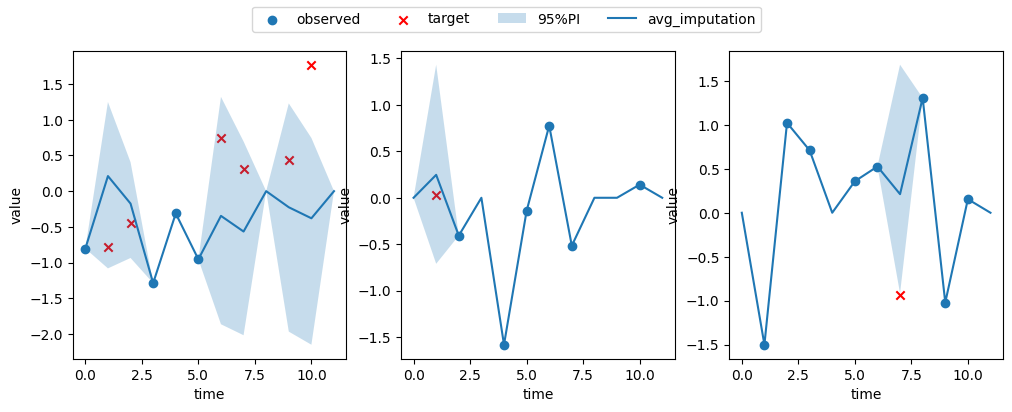

In [27]:
import matplotlib.pyplot as plt
import numpy as np


def imputation_viz(
    real_data: torch.Tensor,
    gen_data: torch.Tensor,
    cond_mask: torch.BoolTensor,
    data_mask: torch.BoolTensor,
    max_viz_n_channel=3,
    save_root=None,
):
    target_mask = data_mask.float() - cond_mask.float()
    target_mask = target_mask.bool()
    for sample_axis in range(gen_data.shape[-1]):
        gen_data[..., sample_axis][~target_mask] = real_data[~target_mask]

    q = torch.tensor([0.05, 0.95])
    gen_data_quantiles = torch.quantile(gen_data, q, dim=-1)
    n_channel = real_data.shape[-1]
    n_channel = min(max_viz_n_channel, n_channel)
    fig, axs = plt.subplots(1, n_channel, figsize=[12, 4])
    axs = axs.flatten()
    t = range(real_data.shape[1])
    for i in range(n_channel):
        sample_id = torch.randint(0, len(real_data), ())
        real_data_plt = real_data.masked_fill(~cond_mask, torch.nan)
        target_data_plt = real_data.masked_fill(~target_mask, torch.nan)

        obs_line = axs[i].scatter(
            t, real_data_plt[sample_id, :, i], c="C0", marker="o", label="observed"
        )
        target_line = axs[i].scatter(
            t, target_data_plt[sample_id, :, i], c="red", marker="x", label="target"
        )
        impute_interval = axs[i].fill_between(
            t,
            gen_data_quantiles[0, sample_id, :, i],
            gen_data_quantiles[-1, sample_id, :, i],
            label="95%PI",
            alpha=0.25,
        )
        [impute_line] = axs[i].plot(
            t, torch.mean(gen_data, dim=-1)[sample_id, :, i], label="avg_imputation"
        )
        # axs[i].legend()
        axs[i].set_xlabel("time")
        axs[i].set_ylabel("value")
    fig.savefig(save_root)
    fig.legend(
        handles=[obs_line, target_line, impute_interval, impute_line], loc="upper center", ncol=4
    )


gen_data = torch.stack([torch.randn_like(x) for _ in range(10)], dim=-1)
imputation_viz(
    x, gen_data, ~torch.isnan(cond_data), observed_masks, save_root="./test_impute.png"
)

In [ ]:
from src.model.flow.fourierflow._fourier import DFT, reconstruct_DFT
import numpy as np
import torch

t = np.linspace(0, 6, 65)
k = int(len(t) / 2) + 1

x = np.sin(t) + np.random.randn(*t.shape) * 0.1

x = x.reshape(-1, len(t))
x = torch.from_numpy(x)
m = DFT(x.shape[1])
z, log_pz, log_jacob = m(x)
z = torch.complex(z[:, 0, :], z[:, 1, :])
print("FF implement")
print(z.shape)
print(z)

print("torch.fft.rfft implement")
x_torch_fft = torch.fft.rfft(x) / len(t)
print(x_torch_fft.shape)
x_torch_fft = x_torch_fft.flip(dims=[1]).conj().type_as(z)
print(x_torch_fft.shape)
print(x_torch_fft)
torch.testing.assert_close(x_torch_fft, z)

# x_torch_fft = np.fft.fft(x)
# x_torch_fft = np.fft.fftshift(x_torch_fft)
# print(x_torch_fft.shape)
# print(x_torch_fft)

# x_torch = torch.complex(x_numpy[:,0,:], x_numpy[:,1,:])
# print(x_torch.shape)
# x_irfft = torch.fft.irfft(x_torch, dim=1)
# x_irfft.shape

# x_numpy_r = reconstruct_DFT(x_numpy[0, :, :], component="real").detach().numpy()

# x_numpy_i = reconstruct_DFT(x_numpy[0, :, :], component="imag").detach().numpy()
# print(x_numpy_r.shape)
# print(x_numpy_i.shape)
# np.real(np.fft.ifft(np.fft.ifftshift(x_numpy_r + 1j * x_numpy_i))).shape


In [ ]:
from io import StringIO
import pandas as pd
import requests

# url = 'https://raw.githubusercontent.com/jsyoon0823/TimeGAN/refs/heads/master/data/stock_data.csv'
url = 'https://raw.githubusercontent.com/jsyoon0823/TimeGAN/refs/heads/master/data/energy_data.csv'
headers = {"Authorization": "Test"}
response = requests.get(url, headers=headers)
df = pd.read_csv(StringIO(response.text))
df

In [ ]:
import os
import numpy as np
import torch
from torchvision.datasets.utils import download_url


try:
    from dm_control import suite  # noqa: F401
except ImportError as e:
    raise Exception(
        "Deepmind Control Suite is required to generate the dataset."
    ) from e

env = suite.load("hopper", "stand")
physics = env.physics

# Store the state of the RNG to restore later.
st0 = np.random.get_state()
np.random.seed(123)

num_samples = 10
total_seq_len = 1000
seq_dim = 14

data = np.zeros((num_samples, total_seq_len, seq_dim))
for i in range(num_samples):
    with physics.reset_context():
        # x and z positions of the hopper. We want z > 0 for the hopper to stay above ground.
        physics.data.qpos[:2] = np.random.uniform(0, 0.5, size=2)
        physics.data.qpos[2:] = np.random.uniform(
            -2, 2, size=physics.data.qpos[2:].shape
        )
        physics.data.qvel[:] = np.random.uniform(
            -5, 5, size=physics.data.qvel.shape
        )
    for t in range(total_seq_len):
        data[i, t, : seq_dim // 2] = physics.data.qpos
        data[i, t, seq_dim // 2 :] = physics.data.qvel
        physics.step()

# Restore RNG.
np.random.set_state(st0)

print(data)

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, figsize=(10, 6))
axs = axs.flatten()
axs[0].plot(data[0, :, :14])
axs[1].plot(data[1, :, :14])
axs[0].set_title('Hopper qpos')
axs[0].legend() 

In [11]:
import pandas as pd
import requests
from io import StringIO,BytesIO
import gzip
from torchvision.datasets.utils import download_url, download_file_from_google_drive, extract_archive, download_and_extract_archive


# download_file_from_google_drive('1bnrv7gpn27yO54WJI-vuXP5NclE5BlBx', './test', 'test.zip')
# extract_archive('/home/user/workspaces/GenTS/notebooks/test/test.zip')
# download_and_extract_archive("https://drive.google.com/file/d/1bnrv7gpn27yO54WJI-vuXP5NclE5BlBx/view?usp=share_link", './test', './test')

url = "https://raw.githubusercontent.com/jsyoon0823/TimeGAN/refs/heads/master/data/energy_data.csv"

# url = "https://raw.githubusercontent.com/laiguokun/multivariate-time-series-data/master/exchange_rate/exchange_rate.txt.gz"
download_url(url, './test/', 'archive.csv')

# headers = {"Authorization": "Test"}

# response = requests.get(url, headers=headers)
# with gzip.GzipFile(fileobj=BytesIO(response.content)) as gz_file:
#     decompressed_content = gz_file.read().decode('utf-8')  # 二进制转字符串
#     df = pd.read_csv(StringIO(decompressed_content), header=None)

#     # df.to_csv(pre_download_dir, index=False)
# df
# "https://drive.google.com/file/d/1bnrv7gpn27yO54WJI-vuXP5NclE5BlBx/view?usp=share_link"


100%|██████████| 4.40M/4.40M [00:00<00:00, 12.0MB/s]


In [16]:
import pandas as pd

try:
    df = pd.read_csv('/home/user/workspaces/GenTS/notebooks/test/archive.csv', index_col='date')
except Exception as _:
    df = pd.read_csv('/home/user/workspaces/GenTS/notebooks/test/archive.csv', index_col=None)
df

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,60,30,19.890000,47.596667,19.200000,44.790000,19.790000,44.730000,19.000000,45.566667,...,17.033333,45.5300,6.600000,733.5,92.000000,7.000000,63.000000,5.300000,13.275433,13.275433
1,60,30,19.890000,46.693333,19.200000,44.722500,19.790000,44.790000,19.000000,45.992500,...,17.066667,45.5600,6.483333,733.6,92.000000,6.666667,59.166667,5.200000,18.606195,18.606195
2,50,30,19.890000,46.300000,19.200000,44.626667,19.790000,44.933333,18.926667,45.890000,...,17.000000,45.5000,6.366667,733.7,92.000000,6.333333,55.333333,5.100000,28.642668,28.642668
3,50,40,19.890000,46.066667,19.200000,44.590000,19.790000,45.000000,18.890000,45.723333,...,17.000000,45.4000,6.250000,733.8,92.000000,6.000000,51.500000,5.000000,45.410389,45.410389
4,60,40,19.890000,46.333333,19.200000,44.530000,19.790000,45.000000,18.890000,45.530000,...,17.000000,45.4000,6.133333,733.9,92.000000,5.666667,47.666667,4.900000,10.084097,10.084097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19730,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.700000,45.590000,...,23.200000,46.7900,22.733333,755.2,55.666667,3.333333,23.666667,13.333333,43.096812,43.096812
19731,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.700000,45.590000,...,23.200000,46.7900,22.600000,755.2,56.000000,3.500000,24.500000,13.300000,49.282940,49.282940
19732,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.700000,45.730000,...,23.200000,46.7900,22.466667,755.2,56.333333,3.666667,25.333333,13.266667,29.199117,29.199117
19733,420,10,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.700000,45.790000,...,23.200000,46.8175,22.333333,755.2,56.666667,3.833333,26.166667,13.233333,6.322784,6.322784
